In [92]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


In [93]:
#Load the Dataset
dataset = pd.read_csv('dataset.csv')

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.


In [94]:
# Data summary
data_summary = {
    "Total Rows": dataset.shape[0],
    "Total Columns": dataset.shape[1],
    "Column Types": dataset.dtypes.value_counts().to_dict()
}

# Missing values analysis
missing_values = dataset.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]  # Only show columns with missing values

# Statistical summary for numerical features
statistical_summary = dataset.describe()

data_summary, missing_values.head(10), statistical_summary


({'Total Rows': 100000,
  'Total Columns': 82,
  'Column Types': {dtype('int64'): 68, dtype('float64'): 8, dtype('O'): 6}},
 SURVEY_AVG_NPS_SCORE          99635
 SURVEY_AVG_CXI_SCORE          98810
 SURVEY_AVG_CASE_MOOD_SCORE    97556
 DNB_GLOBAL_SALES_REVENUE      38137
 DNB_GLOBAL_EMPLOYEE_COUNT     38137
 SECTOR                        15070
 dtype: int64,
        TENURE_MONTHS  DNB_GLOBAL_SALES_REVENUE  DNB_GLOBAL_EMPLOYEE_COUNT  \
 count  100000.000000              6.186300e+04               6.186300e+04   
 mean       43.069110              3.049351e+09               7.569068e+03   
 std        33.474739              2.298173e+10               7.891647e+04   
 min        -1.000000              1.000000e+00               2.000000e+00   
 25%        21.000000              1.285110e+07               7.900000e+01   
 50%        35.000000              5.596105e+07               2.600000e+02   
 75%        52.000000              2.812486e+08               1.092000e+03   
 max       191.

# Initial Obeservations
## Top 5 Columns with Missing Values:
1. **SURVEY_AVG_NPS_SCORE**: 99,635 missing
2. **SURVEY_AVG_CXI_SCORE**: 98,810 missing
3. **SURVEY_AVG_CASE_MOOD_SCORE**: 97,556 missing
4. **DNB_GLOBAL_SALES_REVENUE**: 38,137 missing
5. **DNB_GLOBAL_EMPLOYEE_COUNT**: 38,137 missing

## Statistical Summary (Key Points)
- **TENURE_MONTHS**: Varies widely, with a minimum of -1 (which might be an error) and a maximum of 191 months.
- **CHURN**: The target variable, with only 0.67% churned customers, indicating a highly imbalanced dataset.

## Imbalanced Dataset
- **Low churn rate**: Suggests class(categories) are not represented equally. This Needs addressing during model training.

## Missing Data
- **High levels of missing data**: Particularly in survey-related scores, requiring careful handling.

## Potential Data Issues
- **Negative values in TENURE_MONTHS and CONTRACT_LENGTH**: May indicate data entry errors.

## Diverse Feature Set
- **Mix of customer profile, usage, and engagement data**: Will help with the churn prediction.



## Next Steps

1. **Data Cleaning**: Address missing values, incorrect data entries, and potential outliers.
2. **Exploratory Data Analysis (EDA)**: Conduct deeper EDA to understand the relationship between individual features and the target variable.
3. **Feature Engineering**: Create new features that could be more predictive of churn.


# Data Cleaning

In [95]:
from sklearn.impute import SimpleImputer
import numpy as np

# Handling missing values
# Inputting missing values for DNB_GLOBAL_SALES_REVENUE and DNB_GLOBAL_EMPLOYEE_COUNT with median
median_imputer = SimpleImputer(strategy='median')
dataset['DNB_GLOBAL_SALES_REVENUE'] = median_imputer.fit_transform(dataset[['DNB_GLOBAL_SALES_REVENUE']])
dataset['DNB_GLOBAL_EMPLOYEE_COUNT'] = median_imputer.fit_transform(dataset[['DNB_GLOBAL_EMPLOYEE_COUNT']])

# For survey scores with a high percentage of missing values, we'll impute with a default value indicating no response
# This approach retains the information that these surveys were not filled
dataset['SURVEY_AVG_NPS_SCORE'].fillna(-1, inplace=True)
dataset['SURVEY_AVG_CXI_SCORE'].fillna(-1, inplace=True)
dataset['SURVEY_AVG_CASE_MOOD_SCORE'].fillna(-1, inplace=True)

# Correcting data inconsistencies
# Fixing negative values in TENURE_MONTHS and CONTRACT_LENGTH by replacing them with NaN and then replacing those NaN values with the median_inputer.
dataset['TENURE_MONTHS'] = dataset['TENURE_MONTHS'].apply(lambda x: np.nan if x < 0 else x) # for ever x value less than 0 replace with NaN
dataset['CONTRACT_LENGTH'] = dataset['CONTRACT_LENGTH'].apply(lambda x: np.nan if x < 0 else x) # for ever x value less than 0 replace with NaN
dataset['TENURE_MONTHS'] = median_imputer.fit_transform(dataset[['TENURE_MONTHS']])
dataset['CONTRACT_LENGTH'] = median_imputer.fit_transform(dataset[['CONTRACT_LENGTH']])

# Convert date columns to datetime format
dataset['ACCOUNTING_MONTH'] = pd.to_datetime(dataset['ACCOUNTING_MONTH'])
dataset['RENEWAL_MONTH'] = pd.to_datetime(dataset['RENEWAL_MONTH'], utc=True)
dataset['CONTRACT_START_DATE'] = pd.to_datetime(dataset['CONTRACT_START_DATE'], utc=True)

# Check the dataset after these operations
dataset.head()


,SALESFORCEACCOUNTID,ACCOUNTING_MONTH,RENEWAL_MONTH,CONTRACT_START_DATE,REGION,SECTOR,TENURE_MONTHS,DNB_GLOBAL_SALES_REVENUE,DNB_GLOBAL_EMPLOYEE_COUNT,CONTRACT_LENGTH,...,SUM_HIGH_CASES,SUM_MEDIUM_CASES,SUM_LOW_CASES,SUM_STANDARD_CASES,SUPPORT_CASE_NUMBEROFSLABREACHES,BACKLOG,SURVEY_AVG_CXI_SCORE,SURVEY_AVG_NPS_SCORE,SURVEY_AVG_CASE_MOOD_SCORE,CHURN
0,0011N00001hBZM7QAO,2021-10-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,2020-12-24 00:00:00+00:00,UKI,Professional Services,126.0,55961051.0,260.0,364.0,...,0,0,0,0,0,1,-1.0,-1.0,-1.0,0
1,0011N00001hBZM7QAO,2021-11-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,2020-12-24 00:00:00+00:00,UKI,Professional Services,127.0,55961051.0,260.0,364.0,...,0,0,0,0,0,1,-1.0,-1.0,-1.0,0
2,0011N00001hBZM7QAO,2021-12-01 00:00:00+00:00,2022-12-01 00:00:00+00:00,2021-12-24 00:00:00+00:00,UKI,Professional Services,128.0,55961051.0,260.0,364.0,...,0,0,0,0,0,1,-1.0,-1.0,-1.0,0
3,0011N00001hBZM7QAO,2022-01-01 00:00:00+00:00,2022-12-01 00:00:00+00:00,2021-12-24 00:00:00+00:00,UKI,Professional Services,129.0,55961051.0,260.0,364.0,...,0,0,0,0,0,1,-1.0,-1.0,-1.0,0
4,0011N00001hBZM7QAO,2022-02-01 00:00:00+00:00,2022-12-01 00:00:00+00:00,2021-12-24 00:00:00+00:00,UKI,Professional Services,130.0,55961051.0,260.0,364.0,...,0,0,0,0,0,1,-1.0,-1.0,-1.0,0


## Handling Missing Values

- **High Percentage Missing Values**: 
  - Columns like survey scores with a high percentage of missing values need a decision on whether to impute, drop, or transform.
- **Low Percentage Missing Values**:
  - For columns with fewer missing values, consider imputation using mean, median, or mode. Could potentially use a more sophisticated method like k-NN imputation (however for this we will use our basic statistics for missing vlaues).
- **Specific Replacement Strategies**:
    - `DNB_GLOBAL_SALES_REVENUE` and `DNB_GLOBAL_EMPLOYEE_COUNT` have missing data were replaced using median values.
  - **Survey Scores**:
    - `SURVEY_AVG_NPS_SCORE`, `SURVEY_AVG_CXI_SCORE`, `SURVEY_AVG_CASE_MOOD_SCORE` all have High missing values replaced with a default value of -1, indicating no response.

## Correcting Data Inconsistencies

- **Negative Values**:
  - Address negative values in `TENURE_MONTHS` and `CONTRACT_LENGTH`.
- **Date Columns**:
  - Convert date columns to datetime format and extract information such as month and year.


## Outlier Detection and Handling

- **Identification**:
  - Identify outliers in numerical columns.
- **Handling Strategy**:
  - Decide on a strategy for handling outliers, such as capping or transformation.
  - Specific columns like `ACCOUNTING_MONTH`, `RENEWAL_MONTH`, and `CONTRACT_START_DATE` were converted to datetime format for better handling and feature engineering.


# Feature Engineering

In [96]:
# Feature Engineering
# 1. Temporal Features
dataset['MONTHS_TO_RENEWAL'] = (dataset['RENEWAL_MONTH'] - dataset['ACCOUNTING_MONTH']).dt.days / 30
dataset['CONTRACT_AGE'] = (dataset['ACCOUNTING_MONTH'] - dataset['CONTRACT_START_DATE']).dt.days / 30

# 2. Aggregated and Interaction Features
# Interaction between ARR and SEATS
dataset['ARR_SEATS_INTERACTION'] = dataset['ARR'] * dataset['SEATS']

# 3. Categorical Encoding
# One-hot encoding for categorical variables like REGION and SECTOR
# Note: Depending on the number of unique values, we might need to handle high cardinality differently
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
categorical_columns = ['REGION', 'SECTOR']
encoded_categorical = onehot_encoder.fit_transform(dataset[categorical_columns])

# Creating a DataFrame from the encoded categorical data
encoded_categorical_df = pd.DataFrame(encoded_categorical, 
                                      columns=onehot_encoder.get_feature_names_out(categorical_columns))

# Concatenating the encoded categorical data with the original DataFrame
dataset = pd.concat([dataset, encoded_categorical_df], axis=1)

# Dropping the original categorical columns
dataset.drop(categorical_columns, axis=1, inplace=True)

# Check the dataset after these operations
dataset.head()

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,SALESFORCEACCOUNTID,ACCOUNTING_MONTH,RENEWAL_MONTH,CONTRACT_START_DATE,TENURE_MONTHS,DNB_GLOBAL_SALES_REVENUE,DNB_GLOBAL_EMPLOYEE_COUNT,CONTRACT_LENGTH,ARR,SEATS,...,SECTOR_Not For Profit,SECTOR_Other,SECTOR_Professional Services,SECTOR_Real Estate,SECTOR_Retail & Wholesale,SECTOR_Sci/Tech,SECTOR_Telecommunications,"SECTOR_Transportation, Storage & Delivery","SECTOR_Travel, Hospitality & Catering",SECTOR_nan
0,0011N00001hBZM7QAO,2021-10-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,2020-12-24 00:00:00+00:00,126.0,55961051.0,260.0,364.0,27241.17,330,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0011N00001hBZM7QAO,2021-11-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,2020-12-24 00:00:00+00:00,127.0,55961051.0,260.0,364.0,27241.17,330,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0011N00001hBZM7QAO,2021-12-01 00:00:00+00:00,2022-12-01 00:00:00+00:00,2021-12-24 00:00:00+00:00,128.0,55961051.0,260.0,364.0,30349.76,350,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0011N00001hBZM7QAO,2022-01-01 00:00:00+00:00,2022-12-01 00:00:00+00:00,2021-12-24 00:00:00+00:00,129.0,55961051.0,260.0,364.0,30349.76,350,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0011N00001hBZM7QAO,2022-02-01 00:00:00+00:00,2022-12-01 00:00:00+00:00,2021-12-24 00:00:00+00:00,130.0,55961051.0,260.0,364.0,30349.76,350,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Engineering Steps

**Temporal Features**
- Derive features from date columns, such as the time until renewal or contract age.
- In this case `MONTHS_TO_RENEWAL` = (`RENEWAL MONTH` - `ACCOUNTING MONTH`)/30 (We convert to days prior to /30)
- `CONTRACT_AGE` = `ACCOUNTING_MONTH` - `CONTRACT_START_DATE`

**Aggregated Features & Interaction Features**
- Create aggregated features (e.g., average ARR (annual reccuring revenue) over the past few months) that might capture trends in customer behavior.
- Create interaction terms between features that might jointly have a predictive value (e.g., ARR * SEATS).
- In this case `ARR_SEATS_INTERACTION` = `ARR` * `SEATS`

**Categorical Encoding**
- Convert categorical variables into a format suitable for modeling (e.g., one-hot encoding, label encoding).
- In this case `REGION` & `SECTOR`

Now the dataset includes a more comprehensive set of features that can be used to help predict customer churn.

# Exploratory Data Analysis (EDA)
This phase involves deeper analysis of the dataset to uncover insights and relationships between features and the target variable (CHURN). Key steps in this phase include:

- **Relationship Analysis**:
  - Analyze the relationships between newly created features and the target variable CHURN.
- **Visualization**:
  - Visualize key features to understand their distribution and impact on churn.



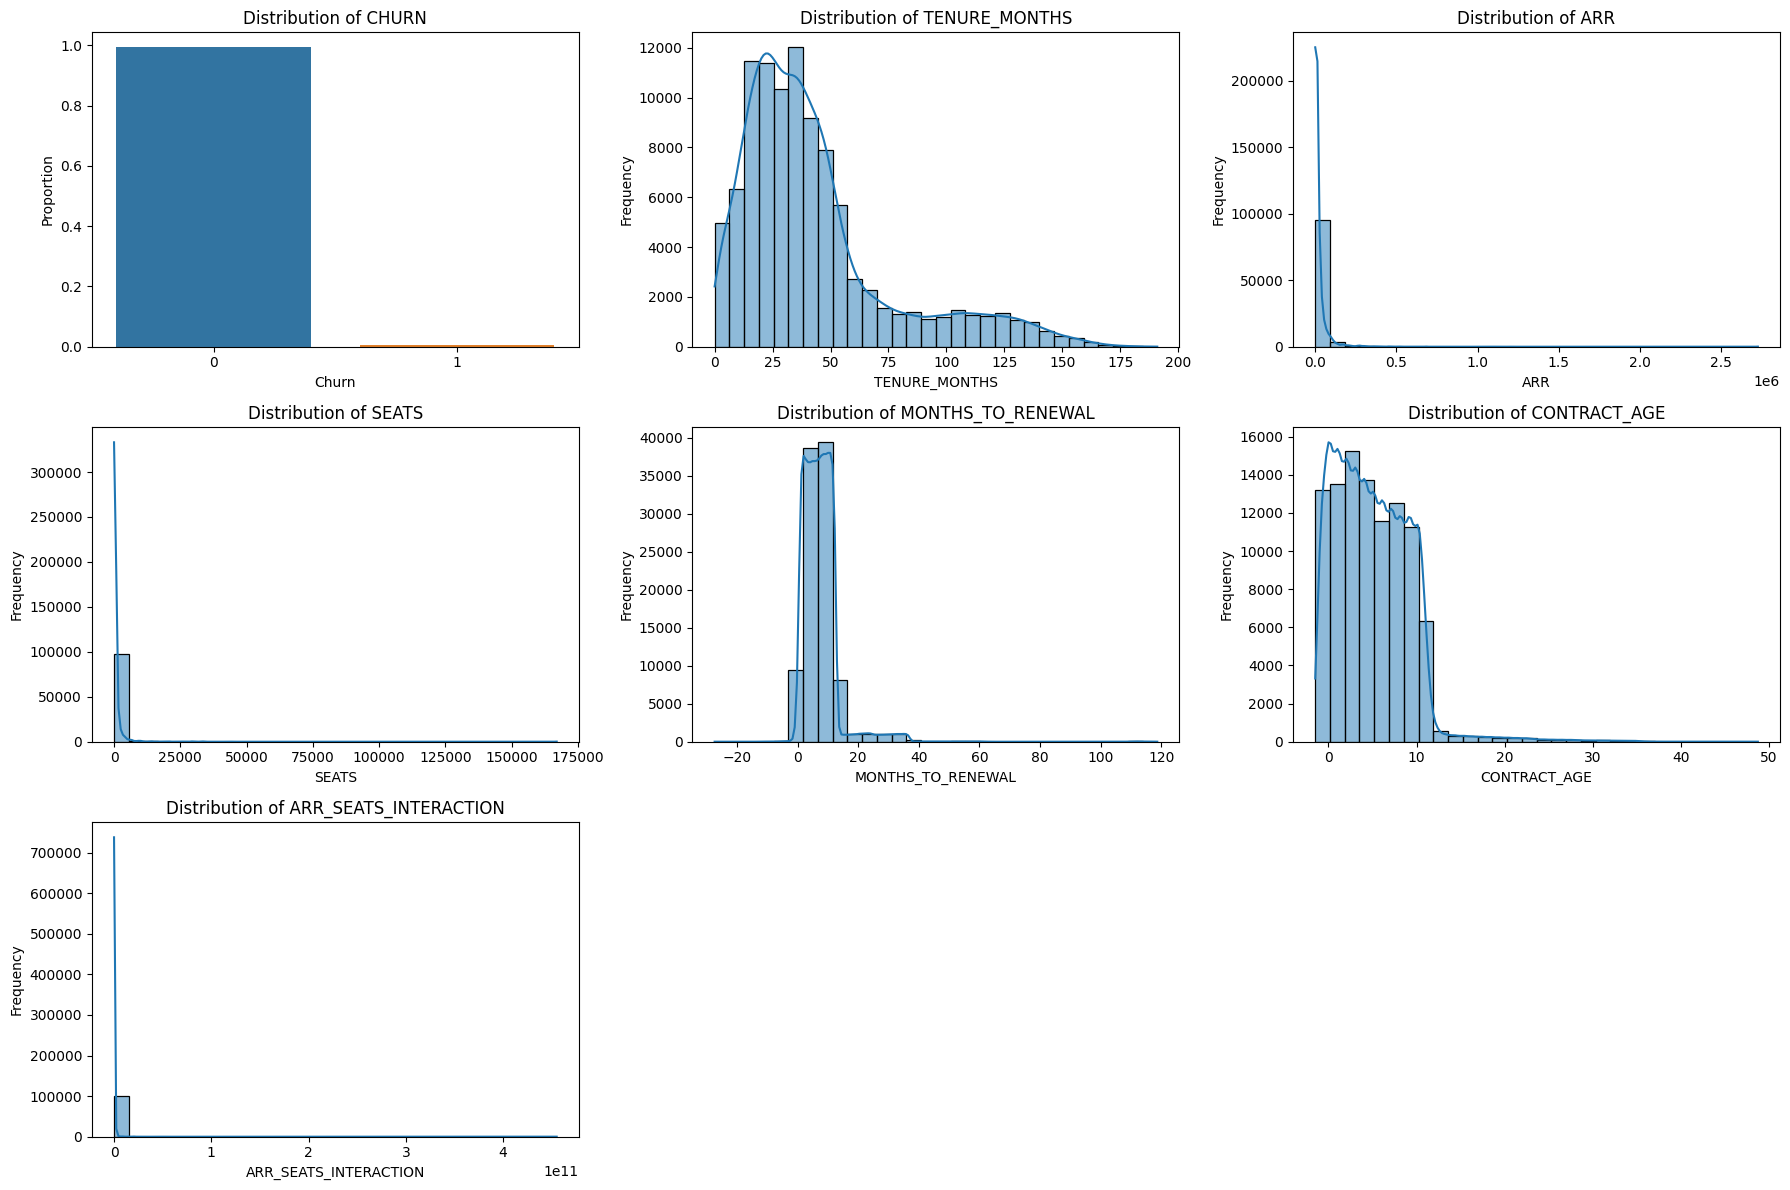

(CHURN                        1.000000
 CUSTOMER_BEHAVIOUR_FOUR      0.202693
 CONTRACT_AGE                 0.075905
 SEATS_DOWNSELL_RECENCY       0.035692
 DETECTEDSEATSCOUNT           0.021347
 CHURN_RISK_DISCUSSION        0.016781
 SECTOR_IT                    0.015083
 ACCOUNTMANAGER_CHANGE        0.013891
 CUSTOMER_BEHAVIOUR_NINE      0.013267
 REGION_RoE                   0.010273
 DNB_GLOBAL_EMPLOYEE_COUNT    0.010156
 Name: CHURN, dtype: float64,
 CONTRACT_START_DATE    -0.025517
 ARR                    -0.026272
 CONTRACT_LENGTH        -0.026712
 PRODUCT_FIVE           -0.032480
 PRODUCT_ONE            -0.033021
 RENEWAL_MONTH          -0.038675
 SEATS_UPSELL_RECENCY   -0.068108
 MONTHS_TO_RENEWAL      -0.085110
 PRODUCT_TWENTYONE            NaN
 PRODUCT_TWENTYTWO            NaN
 Name: CHURN, dtype: float64)

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# EDA: Target Variable Analysis
churn_distribution = dataset['CHURN'].value_counts(normalize=True)

# EDA: Feature Analysis - Selecting a few key features for analysis
key_features = ['TENURE_MONTHS', 'ARR', 'SEATS', 'MONTHS_TO_RENEWAL', 'CONTRACT_AGE', 'ARR_SEATS_INTERACTION']

# Plotting the distribution of the 'CHURN' variable and a few key features
plt.figure(figsize=(18, 12))

# Plot for target variable distribution
plt.subplot(3, 3, 1)
sns.barplot(x=churn_distribution.index, y=churn_distribution.values)
plt.title('Distribution of CHURN')
plt.xlabel('Churn')
plt.ylabel('Proportion')

# Plot for key features
for i, feature in enumerate(key_features, start=2):
    plt.subplot(3, 3, i)
    sns.histplot(dataset[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Drop the 'salesforceaccountid' column
dataset_without_accountid = dataset.drop('SALESFORCEACCOUNTID', axis=1)


# Correlation of features with CHURN
correlations = dataset_without_accountid.corr()['CHURN'].sort_values(ascending=False)

# Display top 10 positively and negatively correlated features
correlations_top_10_positive = correlations.head(11)  # Including CHURN itself
correlations_top_10_negative = correlations.tail(10)

correlations_top_10_positive, correlations_top_10_negative





- `MONTHS_TO_RENEWAL`: -0.085 correlation
- `CONTRACT_AGE`: 0.075905 correlation

## 1. Target Variable Analysis: CHURN
- **Class Imbalance**: Significant imbalance in the CHURN variable, a common issue in churn prediction.
- **Implication for Model Training**: Requires addressing to avoid model bias towards the majority class.

## 2. Key Feature Analysis
- **Tenure Months (TENURE_MONTHS)**: Indicates a range of customer relationships, from new to long-standing.
- **Annual Recurring Revenue (ARR)**: Wide range, suggesting diversity in customer size and revenue contribution.
- **Seats (SEATS)**: Variation in the number of seats per customer.
- **Months to Renewal (MONTHS_TO_RENEWAL)** and **Contract Age (CONTRACT_AGE)**: Potential importance in understanding customer churn related to the contract lifecycle.
- **ARR and Seats Interaction (ARR_SEATS_INTERACTION)**: Distribution of this interaction term may provide insights on its combined effects on churn.

## 3. Correlation Analysis
- **Top Negative Correlations**: Features like MONTHS_TO_RENEWAL and SEATS_UPSELL_RECENCY negatively correlate with CHURN, indicating factors like longer time to renewal and recent seat upsell activities might be linked with lower churn risk.
- **Top Positive Correlations**: Features such as CONTRACT_AGE and CUSTOMER_BEHAVIOUR_FOUR show positive correlations with churn, suggesting they might be risk factors.

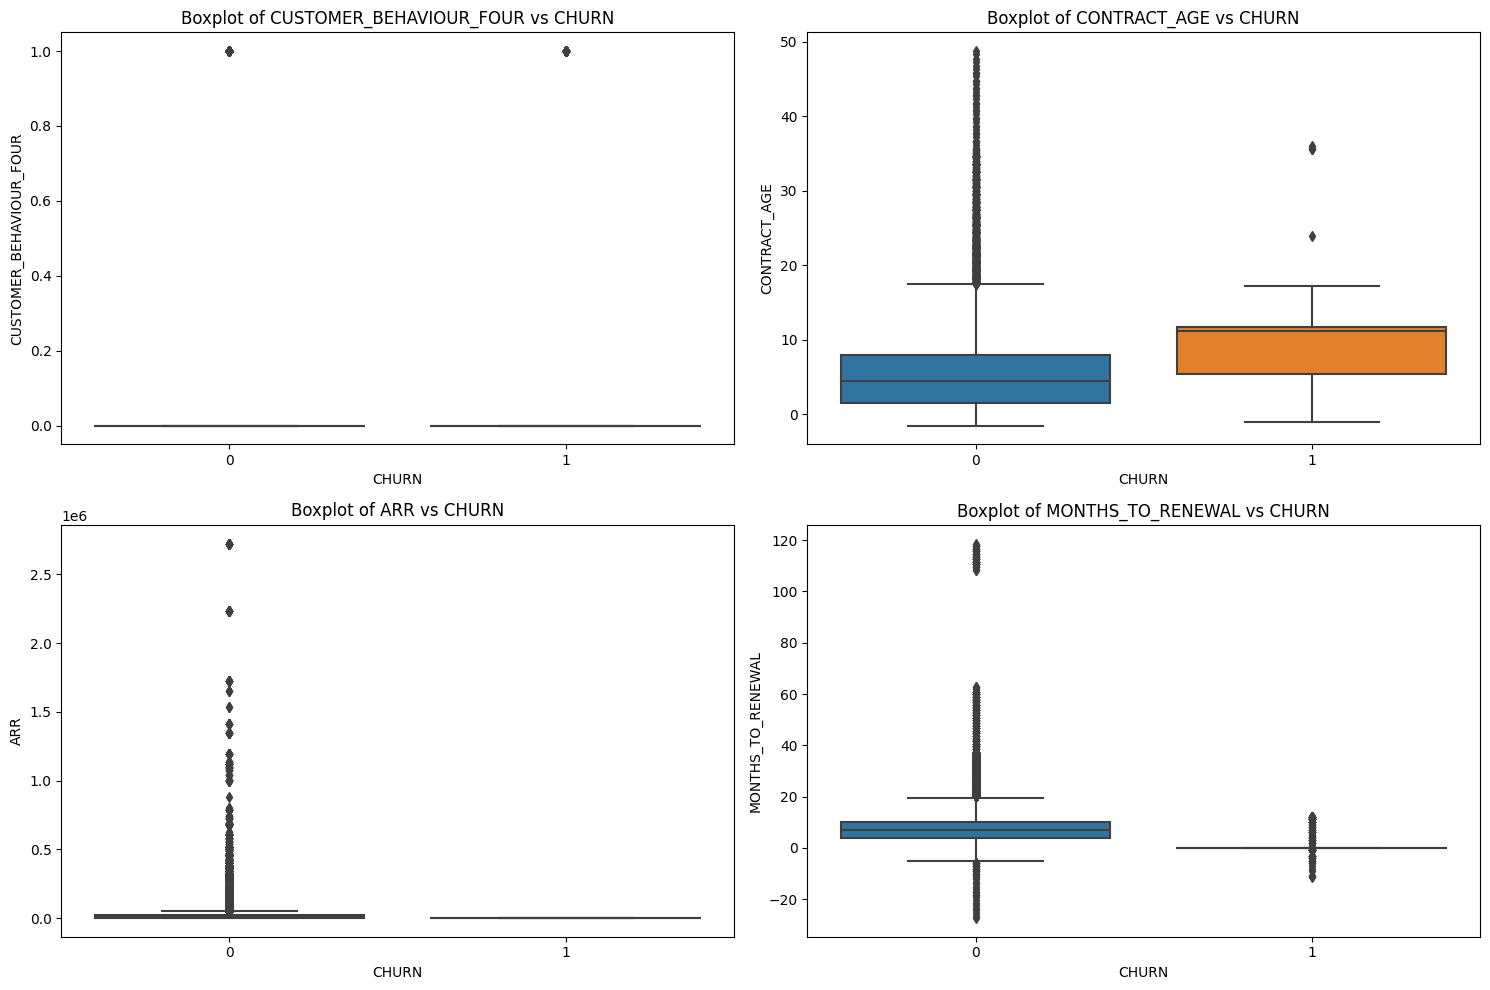

In [98]:
# Visualizing some key features against CHURN

# Selecting a few key features for visualization based on their correlations
features_to_visualize = ['CUSTOMER_BEHAVIOUR_FOUR', 'CONTRACT_AGE', 'ARR', 'MONTHS_TO_RENEWAL']

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

# Plotting each feature
for i, feature in enumerate(features_to_visualize):
    sns.boxplot(x='CHURN', y=feature, data=dataset, ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature} vs CHURN')
    axes[i].set_ylabel(feature)
    axes[i].set_xlabel('CHURN')

plt.tight_layout()
plt.show()

# Visual Analysis Insights

The boxplots provide insights into how different key features vary with respect to the CHURN variable:

- **CUSTOMER_BEHAVIOUR_FOUR**:
  - There is a noticeable difference in the distribution of this feature between churned and non-churned customers, suggesting its potential importance in predicting churn.

- **CONTRACT_AGE**:
  - Churned customers appear to have a slightly different distribution in contract age compared to non-churned customers, indicating that the age of the contract could influence churn.

- **ARR (Annual Recurring Revenue)**:
  - The distribution of ARR shows some differences between the two groups, which might be useful for the model.

- **MONTHS_TO_RENEWAL**:
  - This feature exhibits variation between churned and non-churned customers, potentially indicating its relevance in predicting churn.


## Model Building
After completing the EDA, the next steps involve developing the predictive model:
- **Data Splitting**:
  - Split the dataset into training and testing sets.
- **Training and Evaluation**:
  - Train various machine learning models and evaluate their performance.
- **Model Fine-tuning and Selection**:
  - Fine-tune the models and select the best performing one for churn prediction.

## Data Splitting
- **Dividing the Dataset**: Split the dataset into training and testing sets to prepare for model training and evaluation.

## Model Training
- **Training Different Models**: Train various models and evaluate their initial performance to identify the most promising ones.

## Model Tuning
- **Optimizing Performance**: Adjust and optimize the models to improve their predictive capabilities.

## Model Evaluation
- **Using Informative Metrics**: Employ metrics like precision, recall, and F1-score, which are particularly relevant for imbalanced datasets to thoroughly assess model performance.

In [99]:
# Dropping non-numeric columns that are not useful for modeling (like identifiers)
# Also dropping the original date columns as they have been transformed into more useful features
# Features and target variable
X = dataset_without_accountid.drop('CHURN', axis=1)
y = dataset_without_accountid['CHURN']

columns_to_drop = ['ACCOUNTING_MONTH', 'RENEWAL_MONTH', 'CONTRACT_START_DATE']
X_cleaned = X.drop(columns=columns_to_drop)

# Retry data splitting and scaling
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Confirming the split
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape


((80000, 110), (20000, 110), (80000,), (20000,))

The data has been successfully split and scaled for model training:

- **Training Set Size**: 80,000 samples
- **Testing Set Size**: 20,000 samples
- **Number of Features**: 110

# Model Building
Next, we will train various machine learning models suitable for binary classification tasks. Given the class imbalance, models will be evaluated based on metrics like precision, recall, F1-score, and the area under the ROC curve (AUC). We will start with the following models:

- **Logistic Regression**: A good baseline for binary classification tasks.
- **Decision Tree**: Offers interpretability and handles non-linear relationships well.
- **Random Forest**: An ensemble method that often provides high accuracy.

**For each model, we will**:

- Train the model on the training set.
- Evaluate its performance on the testing set.

In [100]:
# Initializing models
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)

# Training and evaluating each model
models = [logistic_regression, decision_tree, random_forest]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']
performance_summary = {}

for model, name in zip(models, model_names):
    # Training the model
    model.fit(X_train_scaled, y_train)
    
    # Predicting on the test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluating the model
    classification_report_dict = classification_report(y_test, y_pred, output_dict=True)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    performance_summary[name] = classification_report_dict
    performance_summary[name]['AUC'] = auc_score

performance_summary['Logistic Regression'], performance_summary['Decision Tree'], performance_summary['Random Forest']

({'0': {'precision': 0.996042282450779,
   'recall': 0.999949705778806,
   'f1-score': 0.9979921694608976,
   'support': 19883.0},
  '1': {'precision': 0.9743589743589743,
   'recall': 0.3247863247863248,
   'f1-score': 0.48717948717948717,
   'support': 117.0},
  'accuracy': 0.996,
  'macro avg': {'precision': 0.9852006284048767,
   'recall': 0.6623680152825654,
   'f1-score': 0.7425858283201924,
   'support': 20000.0},
  'weighted avg': {'precision': 0.9959154350984419,
   'recall': 0.996,
   'f1-score': 0.9950039152695513,
   'support': 20000.0},
  'AUC': 0.9573788715266359},
 {'0': {'precision': 0.9999497083081875,
   'recall': 1.0,
   'f1-score': 0.9999748535217642,
   'support': 19883.0},
  '1': {'precision': 1.0,
   'recall': 0.9914529914529915,
   'f1-score': 0.9957081545064378,
   'support': 117.0},
  'accuracy': 0.99995,
  'macro avg': {'precision': 0.9999748541540938,
   'recall': 0.9957264957264957,
   'f1-score': 0.997841504014101,
   'support': 20000.0},
  'weighted avg':

## Model Performance Analysis

The analysis of different models yields the following insights:


- The **Random Forest** model shows the highest performance across all metrics, including an exceptional AUC score, suggesting it's very effective at distinguishing between the classes.

- The **Decision Tree** also performs well, especially in terms of recall and precision for the minority class (churned customers).

- The **Logistic Regression** model, while having decent overall accuracy, shows lower recall for the minority class, indicating it might miss identifying some churned customers.

## Observations and Considerations
Given these results, the Random Forest model appears to be the most promising. However, the extremely high performance, particularly in the case of the Random Forest and Decision Tree, suggests a potential overfitting issue, which should be investigated further with techniques like cross-validation and by reviewing the model's complexity.

# Next Steps

The following steps are recommended to refine and finalize the model for churn prediction:


- **Model Tuning and Cross-Validation**: Fine-tune the models, especially the Random Forest, to address potential overfitting.

- **Feature Importance Analysis**: Likely the Random Forest, analyze which features are most influential in predicting churn.

- **Final Evaluation and Selection**: Based on the results of the tuning and additional validations, select the final model for the churn prediction task.


In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Reinitializing the Random Forest model
random_forest = RandomForestClassifier(random_state=42)

# Simplified grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [10, 20],       # Maximum depth of the tree
    'min_samples_split': [2, 4]  # Minimum number of samples required to split an internal node
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# Fitting the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score


({'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 200},
 0.9999900490658528)

In [115]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model with the best parameters
optimal_rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=20, 
    min_samples_split=4, 
    random_state=42
)

# Fit the model to your training data (assuming X_train_scaled and y_train are your training data)
optimal_rf_model.fit(X_train_scaled, y_train)

# Generate predictions and probabilities on the test set
y_pred = optimal_rf_model.predict(X_test_scaled)
churn_probabilities = optimal_rf_model.predict_proba(X_test_scaled)[:, 1]


In [117]:
churn_probabilities

array([0.00000000e+00, 2.52525253e-06, 0.00000000e+00, ...,
       1.35766807e-04, 9.43761905e-01, 0.00000000e+00])

In [ ]:
# Convert probabilities to risk scores (example: scale of 0-100)
risk_scores = churn_probabilities * 100

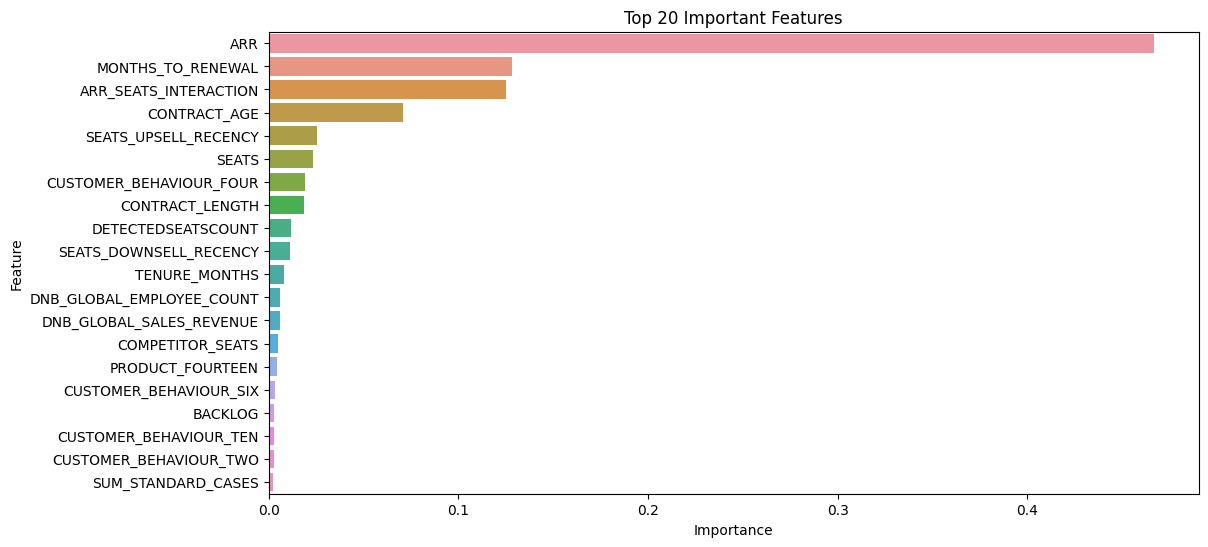

In [113]:
# Extract feature importances from the model
feature_importances = optimal_rf_model.feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=features_df.head(20))
plt.title('Top 20 Important Features')
plt.show()

In [ ]:
# import shap

# # Initialize the SHAP explainer with the Random Forest model
# explainer = shap.TreeExplainer(optimal_rf_model)

# # Calculate SHAP values for the test set
# shap_values = explainer.shap_values(X_test_scaled)

# # Plot SHAP values for a single instance (example: the first instance in the test set)
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0])


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [107]:
# Filter the dataset for the relevant period
X_cleaned_filtered = X_cleaned[X_cleaned['MONTHS_TO_RENEWAL'].between(0, 12)]

# Predict churn probabilities for the filtered dataset
X_cleaned_filtered['Churn_Probability'] = optimal_rf_model.predict_proba(X_cleaned_filtered)[:, 1]

# Convert probabilities to risk scores
X_cleaned_filtered['Risk_Score'] = X_cleaned_filtered['Churn_Probability'] * 100
# dataset_without_accountid

X has feature names, but RandomForestClassifier was fitted without feature names

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [111]:
X_cleaned_filtered

,TENURE_MONTHS,DNB_GLOBAL_SALES_REVENUE,DNB_GLOBAL_EMPLOYEE_COUNT,CONTRACT_LENGTH,ARR,SEATS,COMPETITOR_SEATS,DETECTEDSEATSCOUNT,PRODUCT_ONE,PRODUCT_TWO,...,SECTOR_Professional Services,SECTOR_Real Estate,SECTOR_Retail & Wholesale,SECTOR_Sci/Tech,SECTOR_Telecommunications,"SECTOR_Transportation, Storage & Delivery","SECTOR_Travel, Hospitality & Catering",SECTOR_nan,Churn_Probability,Risk_Score
0,126.0,55961051.0,260.0,364.0,27241.17,330,0,1.015152,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012917,1.291667
1,127.0,55961051.0,260.0,364.0,27241.17,330,0,1.021212,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012917,1.291667
3,129.0,55961051.0,260.0,364.0,30349.76,350,0,0.960000,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010417,1.041667
4,130.0,55961051.0,260.0,364.0,30349.76,350,0,0.940000,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010417,1.041667
5,131.0,55961051.0,260.0,364.0,30349.76,350,0,0.988571,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007917,0.791667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,157.0,420591642.0,5275.0,880.0,18966.39,400,341,0.742500,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.091583,9.158333
99996,158.0,420591642.0,5275.0,323.0,21621.07,400,341,0.735000,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.091583,9.158333
99997,159.0,420591642.0,5275.0,323.0,21621.07,400,0,0.730000,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.081667,8.166667
99998,160.0,420591642.0,5275.0,323.0,21621.07,400,0,0.727500,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.085417,8.541667


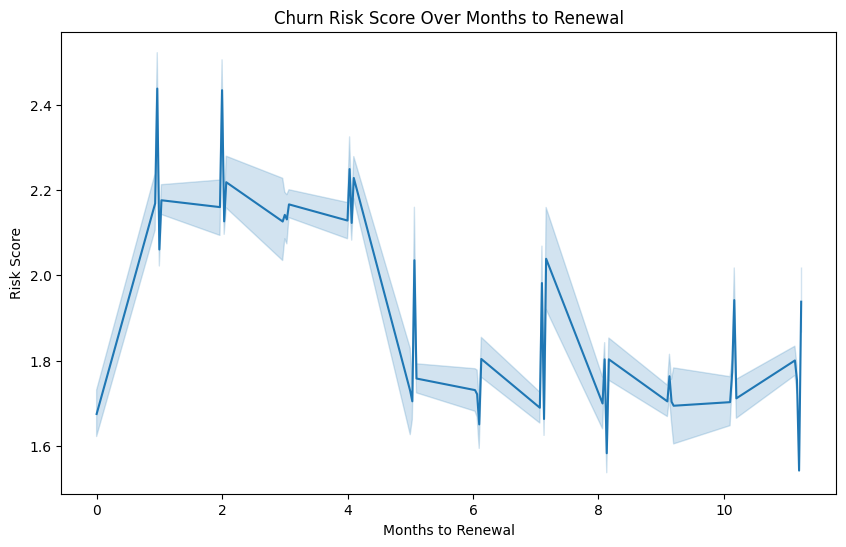

In [110]:
# Visualization of churn risk over months to renewal
plt.figure(figsize=(10, 6))
sns.lineplot(x='MONTHS_TO_RENEWAL', y='Risk_Score', data=X_cleaned_filtered)
plt.title('Churn Risk Score Over Months to Renewal')
plt.xlabel('Months to Renewal')
plt.ylabel('Risk Score')
plt.show()

In [118]:
# Merge the risk score and churn probability back into the original dataset
dataset_with_scores = dataset.merge(
    X_cleaned_filtered[['Churn_Probability', 'Risk_Score']],
    left_index=True,
    right_index=True,
    how='left'
)

In [119]:
dataset_with_scores.to_csv('dataset_with_scores')